## ПЗ 3

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

print(tf.__version__)

2.5.0


### Прогнозирование цен на дома.

В задачах регресии нам требуется прогнозировать непрерывное значение (значение, входящее в какой-либо диапазон, не имеющее набора дискретных значений), как цена или вероятность. 

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [6]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [7]:
print(train_labels[0:10])

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


* Нормализуем данные. 

In [8]:
# Тестовые данные не используются при вычислении mean и std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # Первый тренировочный пример, нормализованный

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


* Датасет не большой, поэтому глубокую сеть строить не будем (что бы не переобучить сеть).Обойдемся 2-хслойной сетью.

In [9]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu',
                       input_shape=(train_data.shape[1],)),
        keras.layers.Dense(32, activation='linear'),
        keras.layers.Dense(1, activation='relu')
    ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=['mae'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


* Познакомился с 'keras.callbacks'. Обратные вызовы (Callbacks) могут быть переданы в методы keras, такие как обучение (.fit), оценка (.evaluate) и прогнозирование (.predict), чтобы подключиться к различным этапам жизненного цикла обучения модели и вывода.(Фрагмент из документации) Можно создавать подклассы, переопределять в них методы. На мой взгляд очень полезная команда. Ниже по коду будет пару вариантов ее использования.

In [10]:
# Использавание 'keras.callbacks'
# Отображает прогресс обучения 
# печатая по одной точке на каждую завершенную эпоху 
# (Нашёл в интернете, мне понравилось) 

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')

EPOCHS = 500

# Сохраняем тренировочную статистику
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()]
                   )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

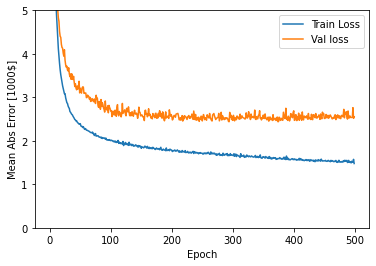

In [11]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, 
           np.array(history.history['mae']),
           label='Train Loss')
    plt.plot(history.epoch, 
           np.array(history.history['val_mae']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

plot_history(history)


........................................................

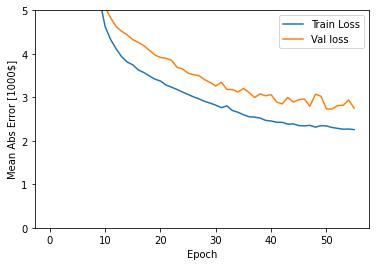

In [12]:
model = build_model()

# Использавание 'keras.callbacks'
# Останавливает обучение при достижении минимума потерь.
# Можно указать patience аргумента, чтобы указать, сколько эпох мы должны подождать, 
# прежде чем останавливаться после достижения локального минимума.

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [13]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=1)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

4/4 [==============================] - 0s 4ms/step - loss: 2.8426 - mae: 2.8426
Testing set Mean Abs Error: $2842.61


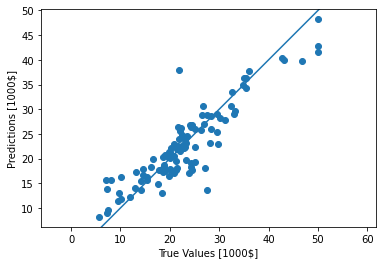

In [14]:
test_predictions = model.predict(test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [1000$]')
plt.ylabel('Predictions [1000$]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

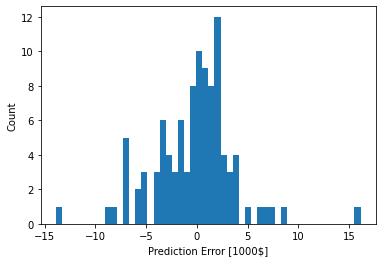

In [15]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [1000$]")
_ = plt.ylabel("Count")

In [16]:
loss_metrics_results = {
    'Losses': [],
    'MSE_train': [],
    'MAE_train': [],
    'MAPE_train': [],
    'MSE_test': [],
    'MAE_test': [],
    'MAPE_test': []
}

In [17]:
for i_loss in [tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanAbsolutePercentageError(), tf.keras.losses.MeanSquaredError(), tf.keras.losses.MeanSquaredLogarithmicError()]:
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu',
                       input_shape=(train_data.shape[1],)),
        keras.layers.Dense(32, activation='linear'),
        keras.layers.Dense(1, activation='relu')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
        loss=i_loss, 
        metrics=['mse', 'mae', 'mape']
    )

    EPOCHS = 200

    history = model.fit(
        train_data, 
        train_labels, 
        epochs=EPOCHS, 
        validation_split=0.2, 
        verbose=0, 
        callbacks=[early_stop]
    )

    mse_tr = round((history.history['mse'][-1]), 4)
    mae_tr = round((history.history['mae'][-1]), 4)
    mape_tr = round((history.history['mape'][-1]), 4)
    
    loss, mse_t, mae_t, mape_t = model.evaluate(test_data, test_labels, verbose = 0)

    loss_metrics_results['Losses'].append(model.loss.get_config()['name'])
    loss_metrics_results['MSE_train'].append(mse_tr)
    loss_metrics_results['MAE_train'].append(mae_tr)
    loss_metrics_results['MAPE_train'].append(mape_tr)
    loss_metrics_results['MSE_test'].append(mse_t)
    loss_metrics_results['MAE_test'].append(mae_t)
    loss_metrics_results['MAPE_test'].append(mape_t)

pd.DataFrame(data=loss_metrics_results)

,Losses,MSE_train,MAE_train,MAPE_train,MSE_test,MAE_test,MAPE_test
0,mean_absolute_error,13.1749,2.2077,10.7884,18.301495,3.078225,14.755659
1,mean_absolute_percentage_error,19.5658,2.5780,11.7190,21.326622,3.405292,16.208450
2,mean_squared_error,11.6284,2.4120,12.0771,22.311914,3.261646,16.784075
3,mean_squared_logarithmic_error,11.7397,2.2859,10.8820,22.463673,3.315989,16.794312


* Лучший вариант показала пара - loss='MeanAbsoluteError()', metrics='mae'

### IMDB_reviews набор данных, содержит тексты 50 000 отзывов к фильмам из Internet Movie Data Вase (IMDB). 

Они разделены на 25 000 отзывов для тренировки и 25 000 отзывов для тестирования. Тренировочный и тестовый наборы сбалансированы - это означает, что они содержат одинаковое количество позитивных и негативных отзывов.

#### Загрузка IMDB набора данных

Датасет уже предобработан так, что отзывы (последовательности слов) конвертированы в последовательности чисел, 
где каждое число представляет специфичное слово в словаре.

In [18]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/nicolay/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/nicolay/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to 

Аргумент 'num_words=10000' сохраняет 10 000 наиболее часто встречающихся слов в тренировочных данных. Редкие слова отсеиваются, чтобы сохранить размер данных управляемым.

#### Исследование данных

Набор приходит предобработанным: каждый пример - это массив чисел, представляющих слова в отзыве фильма. Каждая метка - число со значением 0 или 1, где 0 означает негативный отзыв, а 1 - позитивный отзыв.

In [19]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [20]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Отзывы фильмов могут быть разной длины.

In [21]:
len(train_data[0]), len(train_data[1])

(218, 189)

Отзывы - массивы чисел - должны быть преобразованы в тензоры прежде чем передавать их в нейронную сеть. Это преобразование может быть выполнено двумя путями:

* Одноразовое кодирование (one-hot-encoding) массивов для преобразования их в вектора нулей и единиц. Например, последовательность [3, 5] станет вектором с 10 000 измерений, которые все равны 0, исключая индексы 3 и 5, которые будут равны 1. Затем сделаем первый слой нашей сети - Dense слой - который может обрабатывать нецельночисловые данные векторов. Этот подход затрачивает много памяти, поскольку требует матрицу размера num_words * num_reviews (количество слов * количество отзывов).

* С другой стороны, мы можем заполнить массивы, чтобы все они имели одинаковую длину, затем создадим цельночисловой тензор формы max_length * num_reviews (максимальная длина * количество отзывов). 

Ввиду того что отзывы должны быть одинаковой длины мы используем 'pad_sequences' функцию, чтобы стандартизировать длину:

In [24]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data, value=word_index[""], padding='post', maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=word_index[""], padding='post', maxlen=256)

In [25]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [26]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

Мы можем использовать встроенный слой (embedding layer) способный создать цельночисловой тензор формы max_length * num_reviews (максимальная длина * количество отзывов)

In [27]:
# вводная форма - размер словаря, используемого для отзывов (10 000 слов)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


* Первый слой - это встроенный слой (Embedding layer). Этот слой берет численно-кодированный словарь и ищет встроенный вектор для каждого слова-индекса. Эти вектора обучаются в ходе тренировки модели. Вектора добавляют измерение для массива вывода. Итоговые измерения следующие: (пакет, последовательность, встроенность) (batch, sequence, embedding).
* Далее GlobalAveragePooling1D слой возвращает выводной вектор фиксированной длины для каждого примера путем усреднения по размерности последовательности. Это позволяет модели обрабатывать ввод переменной длины простейшим возможным способом.
* Этот выводной вектор фиксированной длины проходят через полносвязанный (Dense) слой с 16 нейронами.
* Последний слой тесно связан с единственным выводным узлом, использующий сигмоидную функцию активации. Это значение нецельночисловое между 0 и 1, представляющее вероятность.


In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [30]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5)



history = model.fit(train_data, 
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[early_stop, PrintDot()]
                   )


............................

In [31]:
results = model.evaluate(test_data, test_labels)

print(results)

782/782 [==============================] - 6s 8ms/step - loss: 0.3015 - accuracy: 0.8776
[0.3014529049396515, 0.877560019493103]


In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

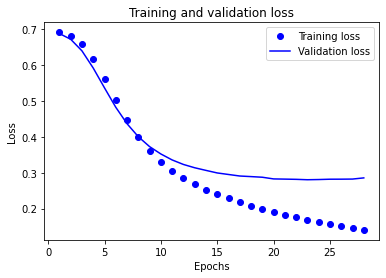

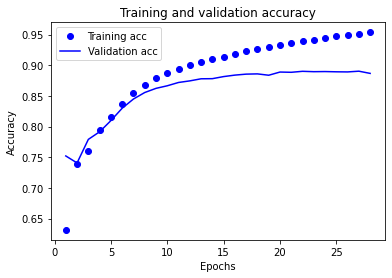

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # очистка фигуры
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()